<a href="https://colab.research.google.com/github/Sinethemba-nongqoto/Research-project/blob/master/Copy_of_Sentiment_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'1.15.2'

In [3]:
# importing libraries
import pandas as pd
import numpy as np


In [4]:
# reading data from google drive
features_sentiment = pd.read_csv('./drive/My Drive/Sentiment_analysis/Data/Copy of bert_features_sentiment.csv', sep=',', header = None)
features_stance = pd.read_csv('./drive/My Drive/Sentiment_analysis/Data/Copy of bert_features_stance.csv', sep=',', header = None)
twitter_stance = pd.read_csv('./drive/My Drive/Sentiment_analysis/Data/Copy of twitter_stance.csv', sep=',', header = None)
data_sentiment = pd.read_csv('./drive/My Drive/Sentiment_analysis/Data/Copy of data_sentiment.csv', sep=',', header = None)

In [ ]:
# 

In [ ]:
sentiment = data[3]
sentiment  = np.array(sentiment)
#load the vectors embedded by BERT
vector_bert = pd.read_csv('./drive/My Drive/Colab Notebooks/bert_features_sentiment.csv', sep=',', header = None)
vector_bert

In [ ]:

label_new = [0]*len(sentiment)
for i in range(len(sentiment)):
  if sentiment[i] == 1:
    label_new[i]=0
  elif sentiment[i] == 2:
    label_new[i]=1
  elif sentiment[i] == 3:
    label_new[i]=2
  elif sentiment[i] == 4:
    label_new[i]=3

In [ ]:
import keras
import numpy as np
from math import floor
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Layer
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

class VAE:
	def __init__(self, input_dim, latent_dim, hidden_dims, batch_size, optimizer='rmsprop', epsilon_std = .01):
		self.input_dim = input_dim
		self.latent_dim = latent_dim
		self.hidden_dims = hidden_dims
		self.batch_size = batch_size
		self.optimizer = optimizer
		self.epsilon_std = epsilon_std
		self.build_model()

	def build_model(self):
		input_layer = Input(batch_shape=(self.batch_size, self.input_dim))
		self.build_encoder(input_layer)
		self.build_decoder()
		self.autoencoder = Model(input_layer, self.x_decoded_mean)
		vae_loss = self._get_vae_loss()
		self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

	def build_encoder(self, input_layer):
		prev_layer = input_layer
		for q in self.hidden_dims:
			hidden = Dense(q, activation='relu')(prev_layer)
			prev_layer = hidden
		self._build_z_layers(hidden)
		self.encoder = Model(input_layer, self.z_mean)

	def _build_z_layers(self, hidden_layer):
		self.z_mean = Dense(self.latent_dim)(hidden_layer)
		self.z_log_sigma = Dense(self.latent_dim)(hidden_layer)

	def build_decoder(self):
		z = self._get_sampling_layer()
		prev_layer = z
		for q in self.hidden_dims:
			hidden = Dense(q, activation='relu')(prev_layer)
			prev_layer = hidden
		self.x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)

		# Build the stand-alone generator
		generator_input = Input((self.latent_dim,))
		prev_layer = generator_input
		for q in self.hidden_dims:
			hidden = Dense(q, activation='relu')(prev_layer)
			prev_layer = hidden
		gen_x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)
		self.generator = Model(generator_input, gen_x_decoded_mean)

	def _get_sampling_layer(self):
		def sampling(args):
			z_mean, z_log_sigma = args
			epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim),
									  mean=0., stddev=self.epsilon_std)
			return z_mean + z_log_sigma * epsilon
		return Lambda(sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_sigma])

	def _get_vae_loss(self):
		z_log_sigma = self.z_log_sigma
		z_mean = self.z_mean
		def vae_loss(x, x_decoded_mean):
			reconstruction_loss = objectives.mse(x, x_decoded_mean)
			kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
			return reconstruction_loss + kl_loss

		return vae_loss


class VAE_LSTM(VAE):
	def __init__(self, input_dim, latent_dim, hidden_dims, timesteps, batch_size, optimizer='rmsprop', epsilon_std = .01):
		self.input_dim = input_dim
		self.latent_dim = latent_dim
		self.hidden_dims = hidden_dims
		self.batch_size = batch_size
		self.timesteps = timesteps
		self.optimizer = optimizer
		self.epsilon_std = epsilon_std
		self.build_model()

	def build_model(self):
		input_layer = Input(shape=(self.timesteps, self.input_dim,))
		self.build_encoder(input_layer)
		self.build_decoder()
		self.autoencoder = Model(input_layer, self.x_decoded_mean)
		vae_loss = self._get_vae_loss()
		self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

	def build_encoder(self, input_layer):
		prev_layer = input_layer
		for q in self.hidden_dims:
			hidden = LSTM(q)(prev_layer)
			prev_layer = hidden
		self._build_z_layers(hidden)
		self.encoder = Model(input_layer, self.z_mean)

	def build_decoder(self):
		z = self._get_sampling_layer()
		prev_layer = RepeatVector(self.timesteps)(z)
		for q in self.hidden_dims:
			hidden = LSTM(q, return_sequences=True)(prev_layer)
			prev_layer = hidden
		self.x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)

		# Build the stand-alone generator
		generator_input = Input((self.latent_dim,))
		prev_layer = RepeatVector(self.timesteps)(generator_input)
		for q in self.hidden_dims:
			hidden = LSTM(q, return_sequences=True)(prev_layer)
			prev_layer = hidden
		gen_x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)
		self.generator = Model(generator_input, gen_x_decoded_mean)
  

N = len(vector_bert)
train = np.array(vector_bert)
train = train.reshape([N,1,1024])

batch_size = 50
epochs = 300
input_dim = train.shape[-1]
timesteps = train.shape[1]

model = VAE_LSTM(input_dim=input_dim, latent_dim=100, hidden_dims=[32], timesteps=timesteps, batch_size=batch_size)
vae, encoder, generator = model.autoencoder, model.encoder, model.generator
#tf.compat.v1.disable_eager_execution()
vae.fit(train[:floor(N/batch_size)*batch_size],train[:floor(N/batch_size)*batch_size], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(train[N-1-batch_size:N-1],train[N-1-batch_size:N-1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.



Train on 6100 samples, validate on 50 samples
Epoch 1/300
6100/6100 [==============================] - 13s 2ms/step - loss: 0.3489 - val_loss: 0.3816
Epoch 2/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3234 - val_loss: 0.3734
Epoch 3/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3192 - val_loss: 0.3712
Epoch 4/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3178 - val_loss: 0.3700
Epoch 5/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3171 - val_loss: 0.3699
Epoch 6/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3167 - val_loss: 0.3697
Epoch 7/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3164 - val_loss: 0.3696
Epoch 8/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3163 - val_loss: 0.3695
Epoch 9/300
6100/6100 [==============================] - 12s 2ms/step - loss: 0.3162 - val_loss: 0.3695
Epoch 10/300
6100

In [ ]:
import pandas as pd

vector_vae = encoder.predict(np.array(train), batch_size = batch_size)
pd.DataFrame(vector_vae).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/vector_vae.csv', index=False)

In [ ]:
vector_vae = pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/vector_vae.csv') 

In [ ]:
#there are only 2 points in the class with label 0, it can not be applied to ADASYN
#just simply remove it 
vector_vae = np.array(vector_vae)
index = []
for i in range(np.size(label_new, 0)):
  if label_new[i] == 0:
    index.append(i)
if len(index) != 0:
  vector_vae = np.delete(vector_vae, index, axis=0)
  label_new = np.delete(label_new, index, axis=0)

In [ ]:
from imblearn.over_sampling import ADASYN 

ada = ADASYN(random_state=42)
vector_vae_balanced, label_new_balanced = ada.fit_resample(vector_vae, label_new)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
import pandas as pd

pd.DataFrame(vector_vae_balanced).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/vector_vae_balanced.csv', index=False)
pd.DataFrame(label_new_balanced).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/label_new_balanced.csv', index=False)

In [ ]:
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold


class Net(nn.Module):

    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.droprate = 0.95
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim), nn.Dropout(p=self.droprate))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


class CustomDataset(Dataset):
    def __init__(self):
        self.data = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/vector_vae_balanced.csv').values).float()
        self.labels = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/label_new_balanced.csv').values).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.data[idx,:]
        labels = self.labels[idx]
        return sample, labels


In [ ]:
def process(X_train, X_test, y_train, y_test):
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  Y_train = np.array(y_train)
  Y_test = np.array(y_test)
  X_train = torch.from_numpy(X_train).float()
  X_test = torch.from_numpy(X_test).float()
  Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
  Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
  train_dataset = []
  test_dataset = []
  for i in range(len(X_train)):
    train_dataset.append((X_train[i],Y_train[i]))
  for i in range(len(X_test)):
    test_dataset.append((X_test[i],Y_test[i]))
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

#do not standardize the one hot features
def process_sentiment(X_train, X_test, y_train, y_test):
  sentiment_train = X_train[:,len(X_train[0])-5:len(X_train[0])]
  sentiment_test = X_test[:,len(X_test[0])-5:len(X_test[0])]
  X_train = X_train[:,:len(X_train[0])-5]
  X_test = X_test[:,:len(X_test[0])-5]
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = np.hstack((X_train, sentiment_train))
  X_test = np.hstack((X_test, sentiment_test))
  Y_train = np.array(y_train)
  Y_test = np.array(y_test)
  X_train = torch.from_numpy(X_train).float()
  X_test = torch.from_numpy(X_test).float()
  Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
  Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
  train_dataset = []
  test_dataset = []
  for i in range(len(X_train)):
    train_dataset.append((X_train[i],Y_train[i]))
  for i in range(len(X_test)):
    test_dataset.append((X_test[i],Y_test[i]))
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

def classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len_test):
  model = Net(input_dim, 100, 30, 4)
  if torch.cuda.is_available():
    model = model.cuda()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  epoch = 0
  train_loss_list = []
  loss_list = []
  accuracy_list = []
  precision_list = []
  recall_list = []
  F1_list = []
  F1_list_train = []

  for epoch2 in range(0, 0 + totEpoch):
      # model.eval()
      num_TP = [0]*num_class
      num_FP = [0]*num_class
      num_FN = [0]*num_class
      eval_loss = 0
      eval_acc = 0
      eval_TP = [0]*num_class
      eval_FP = [0]*num_class
      eval_FN = [0]*num_class
      precision = [0]*num_class
      recall = [0]*num_class
      F1 = [0]*num_class
      for data in train_loader:
          img, label = data
          if torch.cuda.is_available():
              img = img.cuda()
              label = label.cuda()
          else:
              img = Variable(img)
              label = Variable(label)
          out = model(img)
          loss = criterion(out, label)
          print_loss = loss.data.item()
          _, pred = torch.max(out, 1)
          num_correct = (pred == label).sum()

          for i in range(num_class):
            num_TP[i] = (((pred == i) & (label == i))).sum()
            num_FP[i] = (((pred == i) & (label != i))).sum()
            num_FN[i] = (((pred != i) & (label == i))).sum()
            eval_TP[i] += num_TP[i].item()
            eval_FP[i] += num_FP[i].item()
            eval_FN[i] += num_FN[i].item()
          eval_acc += num_correct.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch+=1

      for i in range(num_class):
        if (eval_TP[i] + eval_FP[i]) == 0:
          precision[i] = 1
        else:
          precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
        if (eval_TP[i] + eval_FN[i]) == 0:
          recall[i] = 1
        else:
          recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
        if (precision[i]+recall[i]) == 0:
          F1[i] = 0
        else:
          F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
      print('Train F1: {:.6f}'.format(
          sum(F1)/num_class,
      ))
      F1_list_train.append(sum(F1)/num_class)

      model.eval()
      print('epoch: {}, loss: {:.4}'.format(epoch2, loss.data.item()))
      train_loss_list.append(loss.data.item())

      # model.eval()
      num_TP = [0]*num_class
      num_FP = [0]*num_class
      num_FN = [0]*num_class
      eval_loss = 0
      eval_acc = 0
      eval_TP = [0]*num_class
      eval_FP = [0]*num_class
      eval_FN = [0]*num_class
      precision = [0]*num_class
      recall = [0]*num_class
      F1 = [0]*num_class
      for data in test_loader:
          img, label = data
          # img = img.view(img.size(0), -1)
          if torch.cuda.is_available():
              img = img.cuda()
              label = label.cuda()

          out = model(img)
          loss = criterion(out, label)
          eval_loss += loss.data.item()*label.size(0)
          _, pred = torch.max(out, 1)
          num_correct = (pred == label).sum()
          for i in range(num_class):
            num_TP[i] = (((pred == i) & (label == i))).sum()
            num_FP[i] = (((pred == i) & (label != i))).sum()
            num_FN[i] = (((pred != i) & (label == i))).sum()
            eval_TP[i] += num_TP[i].item()
            eval_FP[i] += num_FP[i].item()
            eval_FN[i] += num_FN[i].item()
          eval_acc += num_correct.item()
      for i in range(num_class):
        if (eval_TP[i] + eval_FP[i]) == 0:
          precision[i] = 1
        else:
          precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
        if (eval_TP[i] + eval_FN[i]) == 0:
          recall[i] = 1
        else:
          recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
        if (precision[i]+recall[i]) == 0:
          F1[i] = 0
        else:
          F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
      print('Test Loss: {:.6f}, Acc: {:.6f}, Pre: {:.6f}, Rec: {:.6f}, F1: {:.6f}'.format(
          eval_loss / (len_test),
          eval_acc / (len_test),
          sum(precision)/num_class,
          sum(recall)/num_class,
          sum(F1)/num_class
      ))
      loss_list.append(loss.data.item())
      accuracy_list.append(eval_acc / (len_test))
      precision_list.append(sum(precision)/num_class)
      recall_list.append(sum(recall)/num_class)
      F1_list.append(sum(F1)/num_class)
  return [np.array(accuracy_list), np.array(precision_list), np.array(recall_list), np.array(F1_list), np.array(F1_list_train), np.array(loss_list), np.array(train_loss_list)]

def train_model(vector_vae, label, model, totEpoch, num_class, random_s):
  X_train, X_test, y_train, y_test = train_test_split(vector_vae, label, test_size=0.2, random_state = random_s)
  train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
  results= classifier(model, train_loader, test_loader, totEpoch, num_class, len(y_test))
  return results

def train_cross_val(input_dim, vector_vae, label, totEpoch, num_class, k):
  results = [np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch)]
  kf = StratifiedKFold(n_splits=k)
  c = 0
  var_test, var_train = [], []
  F1_train, F1_test = [], []
  Loss_train, Loss_test = [], []
  for train_index, test_index in kf.split(vector_vae, label):
    print('The ', c, ' th fold cross validation:')
    X_train = vector_vae[train_index]
    y_train = label[train_index]
    X_test = vector_vae[test_index]
    y_test = label[test_index]
    train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
    result_list= classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len(y_test))
    var_test.append(result_list[3])
    var_train.append(result_list[4])
    F1_train.append(result_list[4])
    F1_test.append(result_list[3])
    Loss_train.append(result_list[6])
    Loss_test.append(result_list[5])
    for i in range(7):
      results[i] += result_list[i]
  for i in range(7):
    results[i] /= k
  var_test = np.array(var_test)
  var_train = np.array(var_train)
  results.append(np.var(var_train, axis = 0))
  results.append(np.var(var_test, axis = 0))
  return results, F1_train, F1_test, Loss_train, Loss_test

In [ ]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold


batch_size = 128
learning_rate = 0.002

vector_vae = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/vector_vae_balanced.csv').values).float()
label = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/label_new_balanced.csv').values).float()

totEpoch = 100
num_class = 3

results, F1_train, F1_test, Loss_train, Loss_test = train_cross_val(100, vector_vae, label, totEpoch, num_class, 5)

import pandas as pd

pd.DataFrame(results[0]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/accuracy_list.csv', index=False)
pd.DataFrame(results[1]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/precision_list.csv', index=False)
pd.DataFrame(results[2]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/recall_list.csv', index=False)
pd.DataFrame(results[3]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_list.csv', index=False)
pd.DataFrame(results[4]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_list_train.csv', index=False)
pd.DataFrame(results[5]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/loss_list.csv', index=False)
pd.DataFrame(results[6]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/train_loss_list.csv', index=False)
pd.DataFrame(results[7]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/train_var_list.csv', index=False)
pd.DataFrame(results[8]).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/test_var_list.csv', index=False)
pd.DataFrame(F1_train).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_train.csv', index=False)
pd.DataFrame(F1_test).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_test.csv', index=False)
pd.DataFrame(Loss_train).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/Loss_train.csv', index=False)
pd.DataFrame(Loss_test).to_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/Loss_test.csv', index=False)

The  0  th fold cross validation:
Train F1: 0.064694
epoch: 0, loss: 1.591
Test Loss: 1.334995, Acc: 0.331461, Pre: 0.777154, Rec: 0.666667, F1: 0.499297
Train F1: 0.499135
epoch: 1, loss: 1.225
Test Loss: 1.220065, Acc: 0.330056, Pre: 0.515799, Rec: 0.662477, F1: 0.502574
Train F1: 0.433542
epoch: 2, loss: 1.129
Test Loss: 1.127392, Acc: 0.343633, Pre: 1.000000, Rec: 0.333333, F1: 0.333333
Train F1: 0.384798
epoch: 3, loss: 1.099
Test Loss: 1.103334, Acc: 0.375936, Pre: 0.601107, Rec: 0.431342, F1: 0.470744
Train F1: 0.495445
epoch: 4, loss: 1.097
Test Loss: 1.090995, Acc: 0.404494, Pre: 0.601429, Rec: 0.514294, F1: 0.540933
Train F1: 0.540829
epoch: 5, loss: 1.076
Test Loss: 1.076885, Acc: 0.402154, Pre: 0.590439, Rec: 0.525709, F1: 0.505343
Train F1: 0.547707
epoch: 6, loss: 1.044
Test Loss: 1.060678, Acc: 0.433989, Pre: 0.606214, Rec: 0.573568, F1: 0.566041
Train F1: 0.591178
epoch: 7, loss: 1.032
Test Loss: 1.045751, Acc: 0.458801, Pre: 0.618450, Rec: 0.604113, F1: 0.604705
Train 

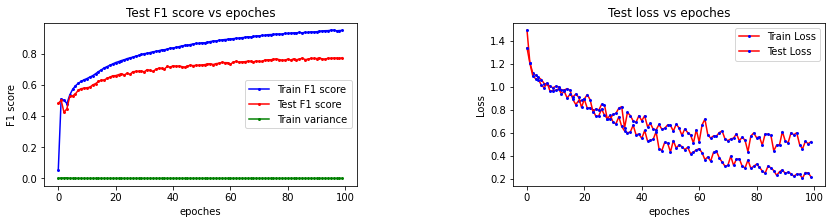

In [ ]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

accuracy_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/accuracy_list.csv').values).float()
precision_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/precision_list.csv').values).float()
recall_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/recall_list.csv').values).float()
F1_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_list.csv').values).float()
F1_list_train = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_list_train.csv').values).float()
loss_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/loss_list.csv').values).float()
train_loss_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/train_loss_list.csv').values).float()
train_var_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/train_var_list.csv').values).float()
test_var_list = torch.from_numpy(pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/test_var_list.csv').values).float()

totEpoch = 100
x = range(0, totEpoch)
plt.figure(figsize=(14,3))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, F1_list, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Test F1 score')
plt.plot(x, train_var_list, color="g", marker='o',markersize='1.5',markeredgecolor='g',markeredgewidth = 1.5, label = 'Train variance')
#plt.plot(x, test_var_list, color="c", marker='o',markersize='1.5',markeredgecolor='c',markeredgewidth = 1.5, label = 'Test variance')
plt.legend()
plt.title('Test F1 score vs epoches')
plt.xlabel('epoches')
plt.ylabel('F1 score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Test Loss')
plt.legend()
plt.title('Test loss vs epoches')
plt.xlabel('epoches')
plt.ylabel('Loss')
plt.show()

In [ ]:
import pandas as pd
F1_list = pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/F1_list.csv').values
F1_list = F1_list.reshape(len(F1_list)).tolist()
test_var_list = pd.read_csv('./drive/My Drive/Colab Notebooks/Sentiment Classification/test_var_list.csv').values
test_var_list = test_var_list.reshape(len(test_var_list)).tolist()
print(max(F1_list))
test_var_list[F1_list.index(max(F1_list))]

0.7731749602948487


0.0016499259296241472